In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import math
import numpy as np
import time
import matplotlib.pyplot as plt

# 设置随机种子，保证结果可复现
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
class MyConv2d(nn.Module):
    """
    手写二维卷积层：使用 Unfold (im2col) + 矩阵乘法实现
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(MyConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding

        # 初始化权重 (Out, In, K_h, K_w)
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, *self.kernel_size) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_channels))

    def forward(self, x):
        n, c, h, w = x.shape
        kh, kw = self.kernel_size
        p = self.padding
        s = self.stride

        # 1. 计算输出尺寸
        out_h = (h + 2 * p - kh) // s + 1
        out_w = (w + 2 * p - kw) // s + 1

        # 2. im2col 展开: [Batch, In_C*kh*kw, L]
        x_unfolded = F.unfold(x, kernel_size=self.kernel_size, padding=p, stride=s)

        # 3. 权重变形: [Out_C, In_C*kh*kw]
        weight_flat = self.weight.view(self.out_channels, -1)

        # 4. 矩阵乘法: [Out_C, In_C*kh*kw] @ [Batch, In_C*kh*kw, L] -> [Batch, Out_C, L]
        output_flat = x_unfolded.transpose(1, 2).matmul(weight_flat.t()).transpose(1, 2)

        # 5. 加偏置
        output_flat = output_flat + self.bias.view(1, -1, 1)

        # 6. Reshape 回图片格式
        output = output_flat.view(n, self.out_channels, out_h, out_w)
        
        return output

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        # 第1层卷积：3通道 -> 16通道
        self.conv1 = MyConv2d(3, 16, kernel_size=3, padding=1)
        # 第2层卷积：16通道 -> 32通道
        self.conv2 = MyConv2d(16, 32, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        # 自适应池化：不管卷积出来多大，都强行变成 4x4
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4)) 
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Conv1 -> Relu -> Pool
        x = self.pool(self.relu(self.conv1(x)))
        # Conv2 -> Relu -> Pool
        x = self.pool(self.relu(self.conv2(x)))
        
        x = self.adaptive_pool(x)
        

        x = x.reshape(-1, 32 * 4 * 4) 
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def get_avg_size(root_dir):
    """计算所有图片宽高的均值（向上取整）"""
    widths, heights = [], []
    valid_ext = ('.jpg', '.png', '.jpeg')
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(valid_ext):
                try:
                    with Image.open(os.path.join(root, file)) as img:
                        widths.append(img.width)
                        heights.append(img.height)
                except:
                    continue
    
    if not widths:
        raise ValueError("未找到图片，请检查路径！")
        
    mean_w = math.ceil(sum(widths) / len(widths))
    mean_h = math.ceil(sum(heights) / len(heights))
    return mean_h, mean_w

class VehicleDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            # 简单的容错处理，防止坏图崩掉整个训练
            print(f"Error loading {path}: {e}")
            return torch.zeros((3, 100, 100)), label


In [ ]:

DATA_ROOT = './cardata'  
BATCH_SIZE = 16


try:
    # 1. 计算均值尺寸
    target_h, target_w = get_avg_size(DATA_ROOT)
    print(f"计算出的 Resize 目标尺寸 (H, W): ({target_h}, {target_w})")

    # 2. 定义 Transform
    data_transform = transforms.Compose([
        transforms.Resize((target_h, target_w)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # 3. 分层划分 (Stratified Split)
    classes = ['bus', 'car', 'truck']
    class_map = {name: i for i, name in enumerate(classes)}

    train_paths, train_labels = [], []
    test_paths, test_labels = [], []

    print("\n数据集划分详情:")
    for cls_name in classes:
        cls_dir = os.path.join(DATA_ROOT, cls_name)
        if not os.path.exists(cls_dir):
            print(f" [Warn] 缺少文件夹: {cls_dir}")
            continue
            
        images = [os.path.join(cls_dir, x) for x in os.listdir(cls_dir) 
                  if x.lower().endswith(('.jpg', '.png', '.jpeg'))]
        np.random.shuffle(images) # 打乱
        
        # 20% 作为测试集
        split_idx = int(len(images) * 0.2)
        test_imgs = images[:split_idx]
        train_imgs = images[split_idx:]
        
        label = class_map[cls_name]
        
        # 添加到列表
        test_paths.extend(test_imgs)
        test_labels.extend([label] * len(test_imgs))
        train_paths.extend(train_imgs)
        train_labels.extend([label] * len(train_imgs))
        
        print(f" -> {cls_name:<6}: 总数 {len(images)} | 训练集 {len(train_imgs)} | 测试集 {len(test_imgs)}")

    # 4. 创建 DataLoader
    train_ds = VehicleDataset(train_paths, train_labels, transform=data_transform)
    test_ds = VehicleDataset(test_paths, test_labels, transform=data_transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
    print(f"\nDataLoader 准备就绪. Step 数量: 训练 {len(train_loader)}, 测试 {len(test_loader)}")

except Exception as e:
    print(f"\n[错误] 数据加载失败: {e}")
    print("请检查 DATA_ROOT 路径下是否包含 bus, car, truck 三个文件夹。")

计算出的 Resize 目标尺寸 (H, W): (111, 94)

数据集划分详情:
 -> bus   : 总数 218 | 训练集 175 | 测试集 43
 -> car   : 总数 779 | 训练集 624 | 测试集 155
 -> truck : 总数 360 | 训练集 288 | 测试集 72

DataLoader 准备就绪. Step 数量: 训练 68, 测试 17


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {DEVICE}")

model = SimpleCNN(num_classes=3).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 用于存储画图数据
history = {
    'train_loss': [], 
    'train_acc': [],
    'test_acc': [],
    'time': []
}

Running on: cuda


In [5]:
EPOCHS = 10 

print(f"{'Epoch':^7} | {'Time(s)':^8} | {'Loss':^8} | {'Train Acc':^10} | {'Test Acc':^10}")
print("-" * 55)

total_start = time.time()

for epoch in range(EPOCHS):
    ep_start = time.time()
    
    # --- 训练阶段 ---
    model.train()
    run_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        
        run_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_train += lbls.size(0)
        correct_train += (preds == lbls).sum().item()
        
    # --- 验证阶段 ---
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total_test += lbls.size(0)
            correct_test += (preds == lbls).sum().item()
            
    # --- 记录数据 ---
    ep_end = time.time()
    ep_time = ep_end - ep_start
    
    avg_loss = run_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    test_acc = 100 * correct_test / total_test
    
    history['train_loss'].append(avg_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)
    history['time'].append(ep_time)
    
    print(f"{epoch+1:^7} | {ep_time:^8.2f} | {avg_loss:^8.4f} | {train_acc:^9.2f}% | {test_acc:^9.2f}%")

print("-" * 55)
print(f"训练结束，总耗时: {time.time() - total_start:.2f}s")

 Epoch  | Time(s)  |   Loss   | Train Acc  |  Test Acc 
-------------------------------------------------------
   1    |   7.80   |  0.9139  |   58.88  % |   72.22  %
   2    |   3.64   |  0.5236  |   77.83  % |   79.63  %
   3    |   3.65   |  0.4084  |   84.27  % |   87.04  %
   4    |   3.45   |  0.3243  |   88.41  % |   87.78  %
   5    |   3.39   |  0.3102  |   87.30  % |   88.52  %
   6    |   3.88   |  0.2902  |   89.42  % |   89.63  %
   7    |   4.73   |  0.2765  |   89.60  % |   87.78  %
   8    |   4.57   |  0.2593  |   89.70  % |   91.48  %
   9    |   4.64   |  0.2392  |   91.72  % |   91.48  %
  10    |   4.04   |  0.2323  |   91.08  % |   92.22  %
-------------------------------------------------------
训练结束，总耗时: 43.79s


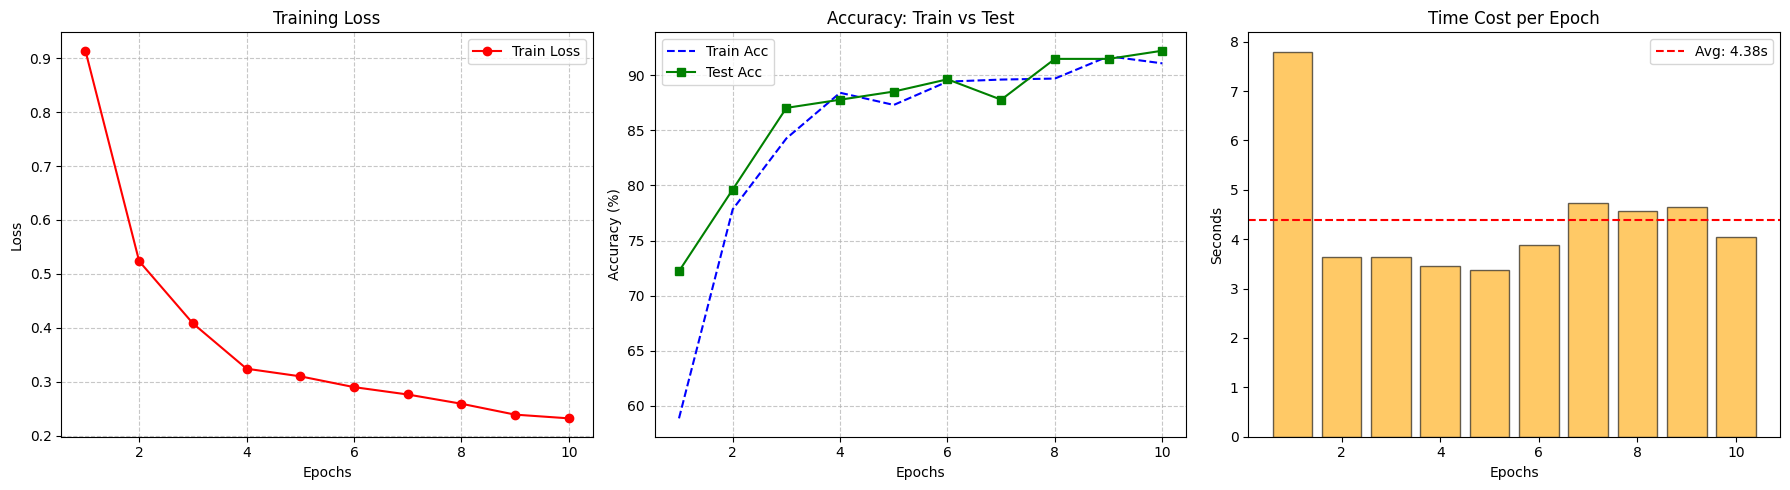

In [6]:
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(18, 5))

# 1. Loss 曲线
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], 'r-o', label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 2. Accuracy 曲线
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], 'b--', label='Train Acc')
plt.plot(epochs_range, history['test_acc'], 'g-s', label='Test Acc')
plt.title('Accuracy: Train vs Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 3. 训练时间
plt.subplot(1, 3, 3)
plt.bar(epochs_range, history['time'], color='orange', alpha=0.6, edgecolor='black')
avg_time = sum(history['time']) / len(history['time'])
plt.axhline(y=avg_time, color='r', linestyle='--', label=f'Avg: {avg_time:.2f}s')
plt.title('Time Cost per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Seconds')
plt.legend()

plt.tight_layout()
plt.show()